In [34]:
import copy
import os
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#################################################################   
####################Physics-Informed Neural Network #############
NUM_EPOCHS = 100000
LEARNING_RATE = 1e-4
NUM_COLLOCATION = 1000
PATIENCE = 1000
THRESHOLD = 1e-3
EARLY_STOPPING_EPOCH = 10000
NUM_SAMPLES = 2000

T_START = 0.0
T_END = 5.0
dt = 0.1

X_MIN = 3.0
X_MAX = 40.0
S_MIN = 0.01
S_MAX = 3.0
V_MIN = 1.0
V_MAX = 3.0
F_MIN = 0.0
F_MAX = 0.1

# --- Model Parameters ---
MU_MAX = 0.86980    # 1/h
K_S = 0.000123762    # g/l
Y_XS = 0.435749      # g/g
S_F = 286           # g/l

# Initial Conditions
X_0, S_0, V_0 = 5, 0.013, 1.7  # Biomass, Substrate, Volume

# ODE solver parameters
ODE_SOLVER = 'LSODA'

In [35]:
def numpy_to_tensor(array):
    return torch.tensor(array, requires_grad=True, dtype=torch.float32).to(DEVICE).reshape(-1, 1)

def grad(outputs, inputs):
    return torch.autograd.grad(outputs.sum(), inputs, create_graph=True)[0]

class PINN(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.input = nn.Linear(input_dim, 256)
        self.hidden = nn.Linear(256, 256)
        self.output = nn.Linear(256, output_dim)

    def forward(self, x):
        x = torch.tanh(self.input(x))
        x = torch.tanh(self.hidden(x))
        x = torch.tanh(self.hidden(x))
        x = self.output(x)
        return x

In [36]:
def generate_dataset(num_samples: int = NUM_SAMPLES):
    """Generate dataset of random multiple initial conditions and control actions"""
    df = pd.DataFrame(columns=['t', 'X', 'S', 'V', 'F'])
    df['X'] = np.random.uniform(X_MIN, X_MAX, num_samples)
    df['S'] = np.random.uniform(S_MIN, S_MAX, num_samples)
    df['V'] = np.random.uniform(V_MIN, V_MAX, num_samples)
    df['F'] = np.random.uniform(F_MIN, F_MAX, num_samples)
    df['t'] = 0.0 # initial time (always 0)
    
    t_train = numpy_to_tensor(df['t'].values)
    X_train = numpy_to_tensor(df['X'].values)
    S_train = numpy_to_tensor(df['S'].values)
    V_train = numpy_to_tensor(df['V'].values)
    F_train = numpy_to_tensor(df['F'].values)
    
    in_train = torch.cat([t_train, X_train, S_train, V_train, F_train], dim=1)
    out_train = torch.cat([X_train, S_train, V_train], dim=1)
    
    return in_train, out_train

def loss_fn(net: nn.Module) -> torch.Tensor:
    t_col = numpy_to_tensor(np.random.uniform(T_START, dt, NUM_COLLOCATION))
    X0_col = numpy_to_tensor(np.random.uniform(X_MIN, X_MAX, NUM_COLLOCATION))
    S0_col = numpy_to_tensor(np.random.uniform(S_MIN, S_MAX, NUM_COLLOCATION))
    V0_col = numpy_to_tensor(np.random.uniform(V_MIN, V_MAX, NUM_COLLOCATION))
    F_col  = numpy_to_tensor(np.random.uniform(F_MIN, F_MAX, NUM_COLLOCATION))
    
    u_col = torch.cat([t_col, X0_col, S0_col, V0_col, F_col], dim=1)
    preds = net.forward(u_col)

    X_pred = preds[:, 0].view(-1, 1)
    S_pred = preds[:, 1].view(-1, 1)
    V_pred = preds[:, 2].view(-1, 1)

    dXdt_pred = grad(X_pred, t_col)
    # dSdt_pred = grad(S_pred, t_col) 
    # dVdt_pred = grad(V_pred, t_col) # not used

    mu = MU_MAX * S_pred / (K_S + S_pred)

    # residuals
    rhs_X = mu * X_pred - (F_col / V_pred) * X_pred
    # rhs_S = - (mu * X_pred) / Y_XS + (F_col / V_pred) * (S_F - S_pred)
    # rhs_V = F_col

    error_dXdt = dXdt_pred - rhs_X
    # error_dSdt = dSdt_pred - rhs_S
    # error_dVdt = dVdt_pred - rhs_V

    # average residual squared loss
    # loss_ode = (torch.mean(error_dXdt**2) +
    #             torch.mean(error_dSdt**2) +
    #             torch.mean(error_dVdt**2)) / 2.0

    loss_ode = torch.mean(error_dXdt**2) # + torch.mean(error_dSdt**2) + torch.mean(error_dVdt**2)
    
    return loss_ode


In [37]:
in_train, out_train = generate_dataset()

print(f'Input shape: {in_train.shape}')
print(f'Output shape: {out_train.shape}')

Input shape: torch.Size([2000, 5])
Output shape: torch.Size([2000, 3])


In [38]:
model_name = "pinc_model_v5.pth"
model_exists = os.path.exists(f'./models/{model_name}')

if model_exists:
    # Load the model
    net = PINN(input_dim=in_train.shape[1], output_dim=out_train.shape[1]).to(DEVICE)
    net.load_state_dict(torch.load(f'./models/{model_name}', weights_only=True))
    net.eval()
else:
    # Main
    net = PINN(input_dim=in_train.shape[1], output_dim=out_train.shape[1]).to(DEVICE)
    optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.9)

    # Loss weights
    w_data, w_ode, w_ic = 1.0, 10.0, 1.0

    # Initialize early stopping variables
    best_loss = float("inf")
    best_model_weights = None
    patience = PATIENCE
    threshold = THRESHOLD
    pretrain_epochs = 0

    for epoch in tqdm(range(NUM_EPOCHS)):
        optimizer.zero_grad()
        preds = net.forward(in_train)
        X_pred = preds[:, 0].view(-1, 1)
        S_pred = preds[:, 1].view(-1, 1)
        V_pred = preds[:, 2].view(-1, 1)
        loss_data = (torch.mean((X_pred - out_train[:, 0].view(-1, 1))**2) + \
                     torch.mean((S_pred - out_train[:, 1].view(-1, 1))**2) + \
                     torch.mean((V_pred - out_train[:, 2].view(-1, 1))**2)) / 3
        if epoch < pretrain_epochs:
            loss = loss_data * w_data
        else:
            loss_ode = loss_fn(net)
            loss = w_data * loss_data + w_ode * loss_ode
        loss.backward()
        optimizer.step()
        # scheduler.step()
        
        if epoch % 1000 == 0:
            if epoch < pretrain_epochs:
                print(f"Epoch {epoch}: Loss = {loss_data.item():.4f}")
            else:
                print(f"Epoch {epoch}: Loss = {loss.item():.4f}, Data Loss = {loss_data.item():.4f}, ODE Loss = {loss_ode.item():.4f}")
        
        # Early stopping
        if epoch >= EARLY_STOPPING_EPOCH:
            if loss.item() < best_loss - threshold:
                best_loss = loss.item()
                best_model_weights = copy.deepcopy(net.state_dict())
                patience = PATIENCE
            else:
                patience -= 1
                if patience <= 0:
                    print(f"Early stopping at epoch {epoch}. Best loss: {best_loss:.4f} at epoch {epoch - PATIENCE}.")
                    break

    # Load best model weights
    if best_model_weights is not None:
        net.load_state_dict(best_model_weights)
        net.eval()
        print("Loaded best model weights.")
    else:
        print("No model weights to load.")
        net.eval()

    # Save the model
    torch.save(net.state_dict(), f'./models/{model_name}')


  0%|          | 18/100000 [00:00<20:53, 79.74it/s] 

Epoch 0: Loss = 241.6842, Data Loss = 190.8180, ODE Loss = 5.0866


  1%|          | 1036/100000 [00:06<09:17, 177.57it/s]

Epoch 1000: Loss = 183.4218, Data Loss = 178.1859, ODE Loss = 0.5236


  2%|▏         | 1984/100000 [00:11<08:43, 187.11it/s]

Epoch 2000: Loss = 186.3389, Data Loss = 180.7889, ODE Loss = 0.5550


  3%|▎         | 3030/100000 [00:17<09:10, 176.14it/s]

Epoch 3000: Loss = 185.1551, Data Loss = 179.2450, ODE Loss = 0.5910


  4%|▍         | 4036/100000 [00:22<08:12, 194.80it/s]

Epoch 4000: Loss = 183.8329, Data Loss = 177.6317, ODE Loss = 0.6201


  5%|▌         | 5044/100000 [00:26<06:03, 261.38it/s]

Epoch 5000: Loss = 182.1172, Data Loss = 175.4660, ODE Loss = 0.6651


  6%|▌         | 6035/100000 [00:32<08:19, 187.94it/s]

Epoch 6000: Loss = 178.6887, Data Loss = 172.0203, ODE Loss = 0.6668


  7%|▋         | 7026/100000 [00:36<06:11, 250.03it/s]

Epoch 7000: Loss = 172.8853, Data Loss = 165.5961, ODE Loss = 0.7289


  8%|▊         | 8034/100000 [00:40<07:31, 203.74it/s]

Epoch 8000: Loss = 159.9242, Data Loss = 153.0719, ODE Loss = 0.6852


  9%|▉         | 9040/100000 [00:45<06:27, 234.61it/s]

Epoch 9000: Loss = 126.9487, Data Loss = 120.0316, ODE Loss = 0.6917


 10%|█         | 10045/100000 [00:49<06:07, 244.77it/s]

Epoch 10000: Loss = 66.6372, Data Loss = 59.2518, ODE Loss = 0.7385


 11%|█         | 11025/100000 [00:53<06:43, 220.66it/s]

Epoch 11000: Loss = 39.0861, Data Loss = 33.5263, ODE Loss = 0.5560


 12%|█▏        | 12024/100000 [00:58<06:48, 215.37it/s]

Epoch 12000: Loss = 24.1302, Data Loss = 20.1111, ODE Loss = 0.4019


 13%|█▎        | 13022/100000 [01:03<08:20, 173.64it/s]

Epoch 13000: Loss = 15.2565, Data Loss = 12.4865, ODE Loss = 0.2770


 14%|█▍        | 14018/100000 [01:08<07:18, 195.97it/s]

Epoch 14000: Loss = 10.6329, Data Loss = 8.7705, ODE Loss = 0.1862


 15%|█▌        | 15032/100000 [01:14<08:01, 176.38it/s]

Epoch 15000: Loss = 8.0131, Data Loss = 6.9923, ODE Loss = 0.1021


 16%|█▌        | 16024/100000 [01:19<08:07, 172.27it/s]

Epoch 16000: Loss = 5.9805, Data Loss = 5.3026, ODE Loss = 0.0678


 17%|█▋        | 17029/100000 [01:25<07:51, 176.04it/s]

Epoch 17000: Loss = 5.0703, Data Loss = 4.6255, ODE Loss = 0.0445


 18%|█▊        | 18025/100000 [01:31<07:53, 173.13it/s]

Epoch 18000: Loss = 5.2434, Data Loss = 4.8716, ODE Loss = 0.0372


 19%|█▊        | 18726/100000 [01:35<06:53, 196.68it/s]

Early stopping at epoch 18726. Best loss: 4.5497 at epoch 17726.
Loaded best model weights.


In [39]:
def train_with_lbfgs(net: nn.Module):
    # Create a new optimizer for L-BFGS
    optimizer = torch.optim.LBFGS(net.parameters(), lr=LEARNING_RATE, max_iter=NUM_EPOCHS, history_size=10, line_search_fn='strong_wolfe')

    # Fine tuning using L-BFGS
    def closure():
        optimizer.zero_grad()
        preds = net.forward(in_train)
        X_pred = preds[:, 0].view(-1, 1)
        S_pred = preds[:, 1].view(-1, 1)
        loss_data = (torch.mean((X_pred - out_train[:, 0].view(-1, 1))**2) + 
                    torch.mean((S_pred - out_train[:, 1].view(-1, 1))**2)) / 2
        loss_ode = loss_fn(net)
        loss = loss_data + loss_ode
        loss.backward()
        return loss

    # Set the model to training mode
    net.train()
    # Run the L-BFGS optimization
    for epoch in tqdm(range(10)):
        optimizer.step(closure)
        if epoch % 100 == 0:
            loss = closure()
            print(f"Epoch {epoch}: Loss = {loss.item():.4e}")
        
    return net

In [40]:
# Load the model
net = PINN(input_dim=in_train.shape[1], output_dim=out_train.shape[1]).to(DEVICE)
net.load_state_dict(torch.load(f'./models/{model_name}', weights_only=True))
net.eval()

def flow_rate(t: float) -> float:
    """Flow rate as a function of time"""
    if t < 0.5:
        return 0.01
    elif t < 5.0:
        return 0.1
    else:
        return 0.00

# System dynamics
def system_dynamics(t: float, y: float, F: Union[callable, float]) -> np.array:
    X, S, V = y
    Fs = F(t) if callable(F) else F
    dX_dt = (MU_MAX * S / (K_S + S)) * X - (Fs / V) * X
    dS_dt = -(1 / Y_XS) * (MU_MAX * S / (K_S + S)) * X + (Fs / V) * (S_F - S)
    dV_dt = Fs
    return np.array([dX_dt, dS_dt, dV_dt])

def solve_ode(ode: callable, t_span: list, y0: list, method: str, t_eval: list, args: tuple) -> solve_ivp:
    sol = solve_ivp(ode, t_span=t_span, y0=y0, method=method, args=args, t_eval=t_eval, rtol=1e-6, atol=1e-12)
    # sol.y = np.maximum(sol.y, 0)
    return sol

sol = solve_ode(system_dynamics, t_span=[T_START, T_END], y0=[X_0, S_0, V_0], method=ODE_SOLVER, \
                t_eval=np.arange(T_START, T_END, dt), args=(flow_rate,))
df = pd.DataFrame(sol.y.T, columns=['X', 'S', 'V'])
df['Time'] = sol.t

T_s = 0.1
t_test = numpy_to_tensor(np.array([df['Time'].values]))
X_test = numpy_to_tensor(np.array([df['X'].values]))
S_test = numpy_to_tensor(np.array([df['S'].values]))
V_test = numpy_to_tensor(np.array([df['V'].values]))
F_test = numpy_to_tensor(np.array([flow_rate(t) for t in df['Time'].values]))
u_test = torch.cat([t_test, X_test, S_test, V_test, F_test], dim=1)
x_test = torch.cat([X_test, S_test, V_test], dim=1)

X_0 = X_test[0]
S_0 = S_test[0]
V_0 = V_test[0]
F_0 = F_test[0]

X_preds = []
S_preds = []
V_preds = []

net.eval()
for i in range(len(u_test)):

    if i == 0:
        X_preds.append(X_0.item())
        S_preds.append(S_0.item())
        V_preds.append(V_0.item())
        continue

    x_k = net.forward(torch.tensor([T_s, X_0, S_0, V_0, F_0], dtype=torch.float32).to(DEVICE))
    X_0 = X_test[i]
    S_0 = S_test[i]
    V_0 = V_test[i]
    F_0 = F_test[i]
    X_preds.append(x_k[0].item())
    S_preds.append(x_k[1].item())
    V_preds.append(x_k[2].item())

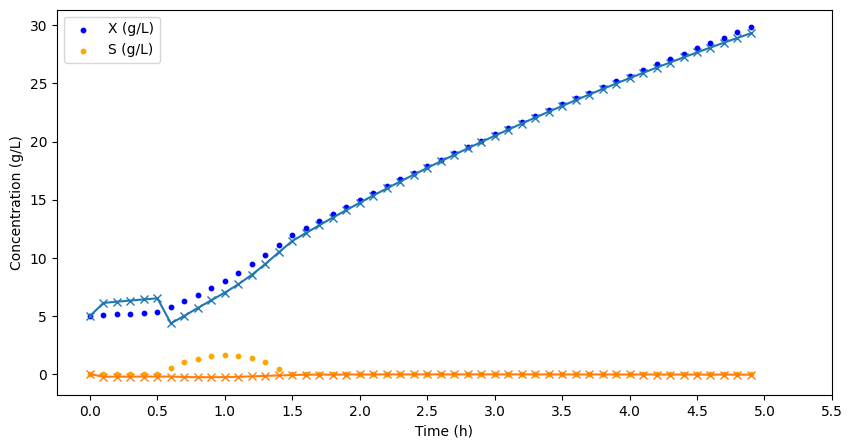

In [41]:
plt.figure(figsize=(10, 5))
plt.scatter(df['Time'], df['X'], label='X (g/L)', color='blue', s=10)
plt.scatter(df['Time'], df['S'], label='S (g/L)', color='orange', s=10)

plt.plot(t_test.detach().cpu().numpy(), X_preds, marker='x', label="_X_pred")
plt.plot(t_test.detach().cpu().numpy(), S_preds, marker='x', label="_S_pred")
plt.ylabel("Concentration (g/L)")
plt.legend(loc="best") 

plt.xticks(np.arange(0, 6, 0.5))
plt.xlabel("Time (h)")
plt.show()